In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [13]:
# Set the directory path
base_dir = '/Users/apple/Desktop/photos dataset'
# Subfolders are:
me_only_dir = os.path.join(base_dir, 'me only')
me_others_dir = os.path.join(base_dir, 'me+others')
others_only_dir = os.path.join(base_dir, 'other only')

In [15]:
def count_valid_images(folder_path):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp','.heic') # Common image formats
    return len([f for f in os.listdir(folder_path) if
f.lower().endswith(valid_extensions)])
    
print(f"'Me only': {count_valid_images(me_only_dir)} images")
print(f"'Me+others': {count_valid_images(me_others_dir)} images")
print(f"'Others only': {count_valid_images(others_only_dir)} images")

'Me only': 60 images
'Me+others': 60 images
'Others only': 60 images


In [33]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [34]:
X = X / 255.0


In [35]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    old_size = img.shape[:2]  # Original size (height, width)
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    img = cv2.resize(img, (new_size[1], new_size[0]))  # Resize by ratio
    delta_w = target_size[1] - new_size[1]
    delta_h = target_size[0] - new_size[0]
    color = [0, 0, 0]  # Black padding
    img = cv2.copyMakeBorder(img, delta_h // 2, delta_h - delta_h // 2,
                             delta_w // 2, delta_w - delta_w // 2,
                             cv2.BORDER_CONSTANT, value=color)
    img = img / 255.0
    return img


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split  # Import train_test_split

def load_images(folder_paths, labels, img_size=(224, 224)):
    """
    Load and preprocess all images from given folders.
    """
    images, image_labels = [], []
    for folder, label in zip(folder_paths, labels):
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)  # Resize to fixed size
                images.append(img)
                image_labels.append(label)
    return np.array(images), np.array(image_labels)


In [37]:
# Define paths and labels
folders = [me_only_dir, me_others_dir, others_only_dir]
labels = [1, 1, 0]  # 1 = "me", 0 = "not me"

# Load and preprocess the data
X, y = load_images(folders, labels)
X = X / 255.0  # Normalize pixel values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model with a Resizing layer to handle variable input sizes
model = models.Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Resizing(224, 224),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='sigmoid')
])


In [40]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [44]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4222 - loss: 1.0277 - val_accuracy: 0.6333 - val_loss: 0.6189
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 898ms/step - accuracy: 0.5325 - loss: 0.7479 - val_accuracy: 0.7667 - val_loss: 0.5625
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 902ms/step - accuracy: 0.6212 - loss: 0.6595 - val_accuracy: 0.7667 - val_loss: 0.5314
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 905ms/step - accuracy: 0.6058 - loss: 0.6837 - val_accuracy: 0.8000 - val_loss: 0.5049
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 991ms/step - accuracy: 0.7303 - loss: 0.5540 - val_accuracy: 0.8000 - val_loss: 0.4830
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 916ms/step - accuracy: 0.6727 - loss: 0.5669 - val_accuracy: 0.8000 - val_loss: 0.4614
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 917ms/step - accuracy: 0.6616 - loss: 0.6164 - val_accuracy: 0.8333 - val_loss: 0.4416
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 995ms/step - accuracy: 0.7893 - loss: 0.4316 - val_accuracy: 0.8667 - val_loss: 0.4234
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


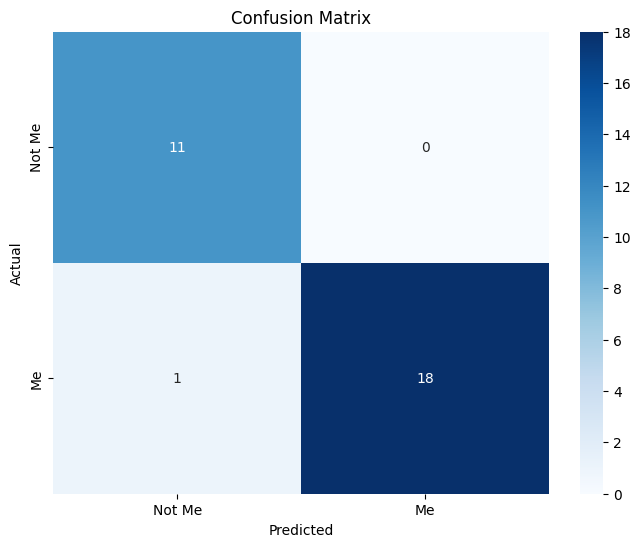

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Me', 'Me'], yticklabels=['Not Me', 'Me'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [48]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step - accuracy: 0.9667 - loss: 0.1570
Test Accuracy: 96.67%
